In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.gain3 import Gain3
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checkerPmd2 import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

# 2. Load the model trained before

In [2]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

g0_bound = [0, 0.1]
gSlope_bound = [0,0]

task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g0_bound = g0_bound, gSlope_bound = gSlope_bound, 
                        noise = 0.25, accumulation_mask = 300)
########################################
#### set weight path
########################################
weightsPath = './weights/gain3Dale0.8.npz'

network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07

        
network_params['load_weights_path'] =  weightsPath

try:
    model.destruct()
except:
    pass

model = Gain3(network_params)
model.output_transfer_function = network_params.get(
    "output_transfer_function", tf.nn.relu
)
model.decision_threshold = network_params.get("decision_threshold", np.inf)

# Test 5000 trials to examine performance

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Overall Accuracy: 0.958
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Overall Accuracy: 0.9552
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Overall Accuracy: 0.9608
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Overall Accuracy: 0.9574
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Overall Accuracy: 0.9568
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Overall Accuracy: 0.9584
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Overall Accuracy: 0.9512
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Overall Accuracy: 0.9574
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Overall Accuracy: 0.9548
Negative RT trials ratio: 0.0


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Overall Accuracy: 0.9578
Negative RT trials ratio: 0.0


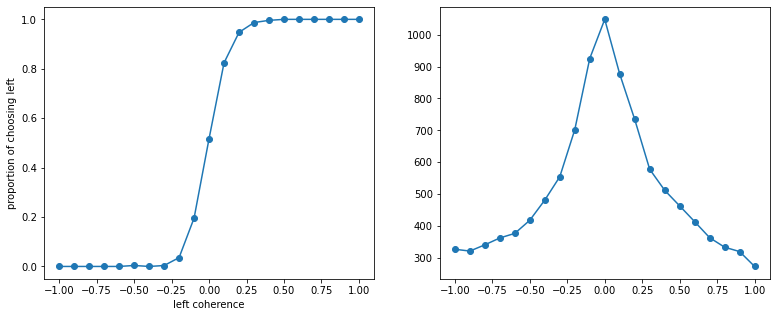

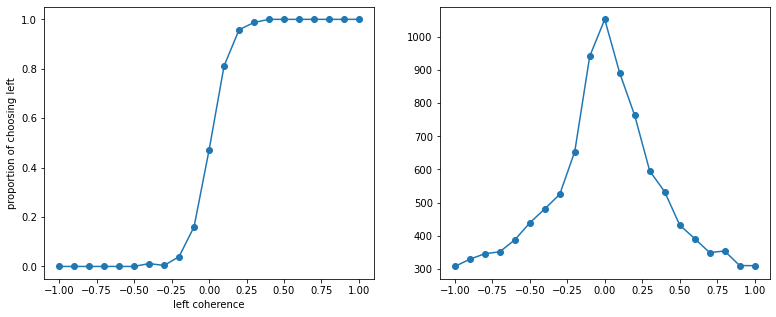

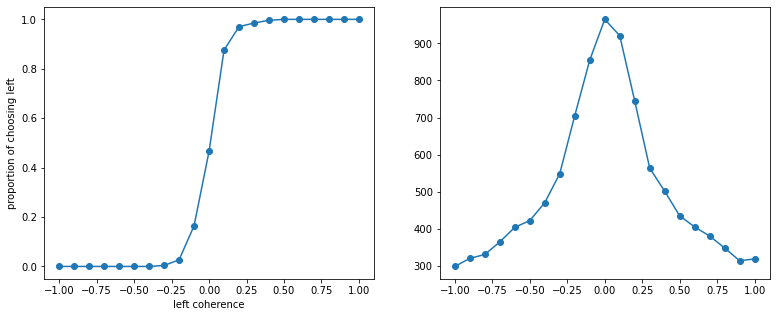

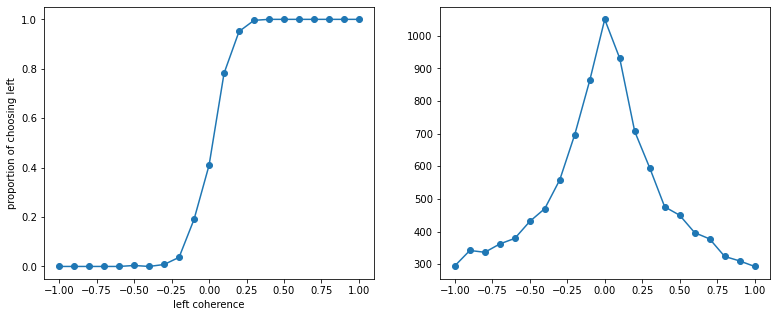

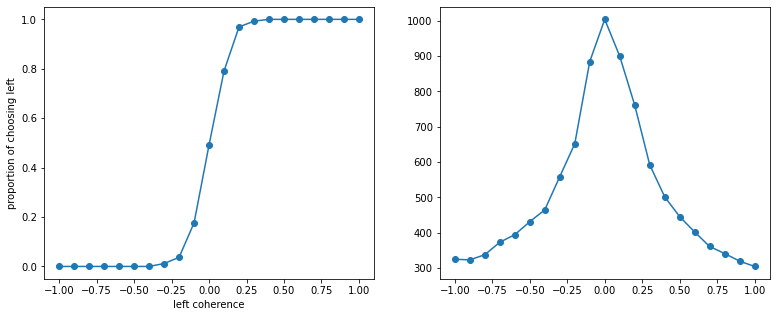

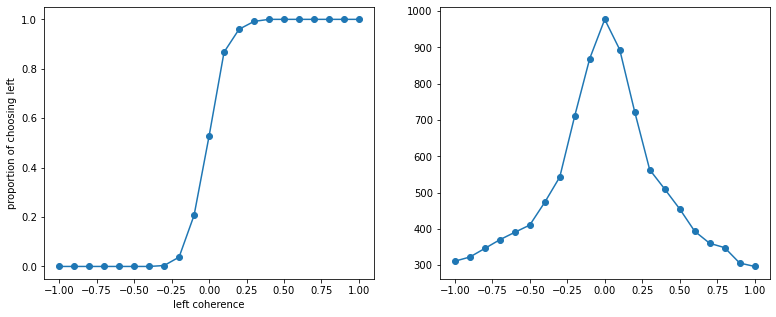

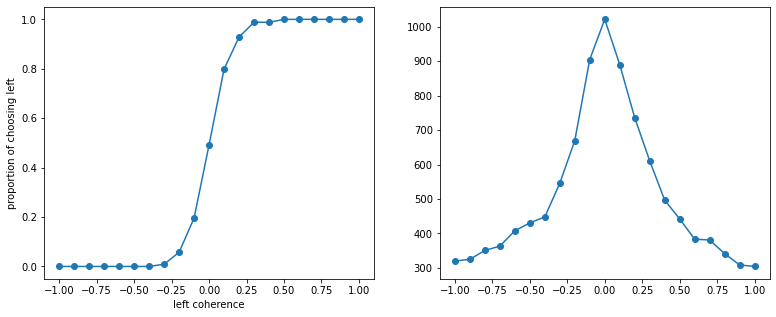

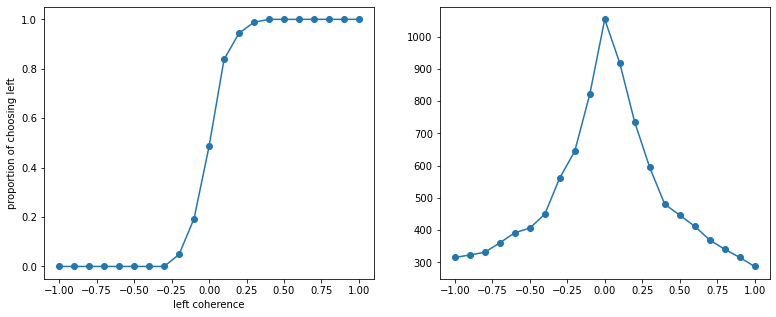

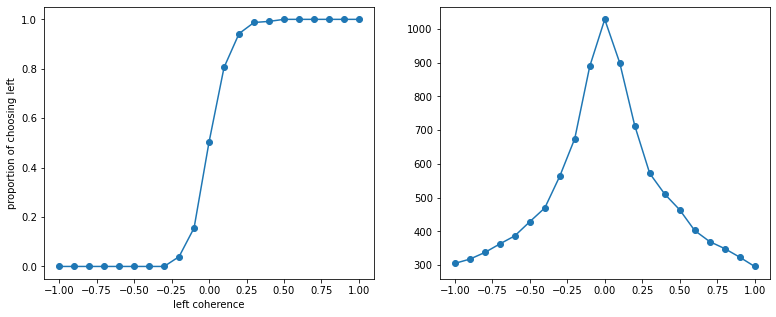

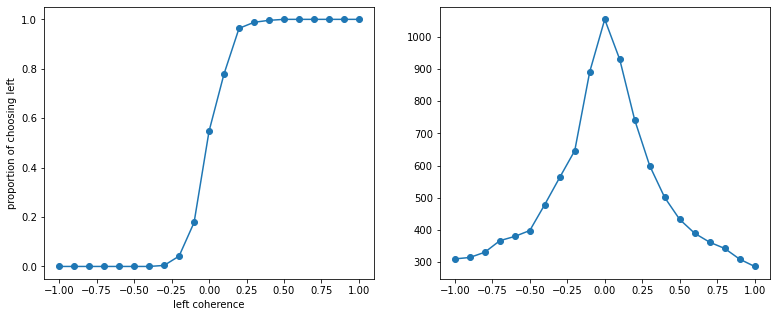

In [5]:
trials = 5000


for itr in range(10):
    batches = int(np.ceil(trials / N_batch))

    rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
    rnn_out = np.zeros((trials, task.N_steps, model.N_out))

    coherence = np.zeros(trials)
    green_side = np.zeros(trials)
    target_onset = np.zeros(trials)
    checker_onset = np.zeros(trials)

    decision = np.zeros(trials)
    rt = np.zeros(trials)
    g0 = np.zeros(trials)
    gSlope = np.zeros(trials)


    # generate 5000 trials and 
    for b in tqdm(range(batches)):
        [x, y, mask, params, g, gainParams] = task.get_trial_batch()
        outputs, states, inputs = model.test(x,g)

        start_index = N_batch * b
        end_index = N_batch * (b + 1)
        rnn_state[start_index:end_index] = states
        rnn_out[start_index:end_index] = outputs

        thr = np.where(outputs > 0.7)

        for i in range(N_batch):
            index = start_index + i

            coherence[index] = params[i]["coherence"]
            target_onset[index] = params[i]["target_onset"]
            checker_onset[index] = params[i]["checker_onset"]

            thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
            thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
            decision[index] = thr_unit
            rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index] 
            g0[index] = gainParams[i][0]
            gSlope[index] = gainParams[i][1]     


    # generate a resultData dataframe 
    correct_side = (coherence > 0.5)
    correct_side = 1 - 1*correct_side

    checker_df = pd.DataFrame({'trial' : np.arange(trials),
                               # the real coherence based on left and right (positive: left evidence dominant
                               # negative: right evidence dominant)
                               'coherence' : 2*coherence - 1,
                               'coherence_bin' : np.round(2*coherence - 1, 1),
                               'correct_side' : correct_side,
                               'target_onset' : target_onset,
                               'checker_onset' : checker_onset,
                               'decision' : decision,
                               'decision_time' : rt,
                               'correct_decision' : (decision == correct_side).astype(int),
                              'g0' : g0,
                              'gSlope' : gSlope})

    checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()

    print("Overall Accuracy: " + str(np.sum(checker_df["correct_decision"])/len(checker_df)))
    print("Negative RT trials ratio: ", end = "")
    print(np.sum(checker_df["decision_time"] < 0)/len(checker_df))

    # save the result summary
    resultPath = '/net/derived/tianwang/psychRNNArchive/resultData/gain3_50kTrials_' + str(itr) + '.csv'
    checker_df.to_csv(resultPath)


    # transpose the data and save as .mat file for analysis on matlab
    temp = np.transpose(rnn_state, (2,1,0))
    from scipy.io import savemat
    savePath = '/net/derived/tianwang/psychRNNArchive/stateActivity/gain3_50kTrials_' + str(itr) + '.mat'
    mdic = {'temp': temp}
    savemat(savePath, mdic)
    
    # psychrometric curve 
    plt.figure(figsize=(13, 5))
    plt.subplot(1,2,1)
    plt.plot(checker_mean['coherence_bin'], 1-checker_mean['decision'])
    plt.scatter(checker_mean['coherence_bin'], 1-checker_mean['decision'])
    plt.xlabel("left coherence")
    plt.ylabel("proportion of choosing left")
    plt.subplot(1,2,2)
    plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
    plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

    


In [ ]:
# model.destruct()